In [1]:
import pyblp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pyblp.options.verbose = False 

In [2]:
# Globals

SIGMA0 = np.eye(2)
SIGMA_BOUNDS = ([[-1e2, -1e2], [-1e2, -1e2]], [[1e2, 1e2], [1e2, 1e2]])
BETA_BOUNDS = ([1e-3, -1e2, 1e-3, 1e-3], [1e2, -1e-3, 1e2, 1e2])
INTEGRATION = pyblp.Integration('product', size = 17)
OPTI = pyblp.Optimization('l-bfgs-b', {'gtol': 1e-6})

### Loading the simulated data

In [3]:
import csv
data = list(csv.reader(open('../temp/zeta_1000.csv')))
column_name = ['product_ids', 'market_ids', 'quality', 'satellite', 'wired', 'prices', 'obs_cost','unobs_demand','unobs_cost','shares', 'marginal_cost','price_elasticity','D1','D2','D3','D4']
product_data = pd.DataFrame(data, columns = column_name)
product_data = product_data.astype('float')
product_data['firm_ids'] = product_data['product_ids']

## 5 Estimate the Correctly Specified Model
### 5 (8) Report a table with the estimates of the demand parameters and standard error
#### (a) When estimating demand alone

In [4]:
# DEMAND INSTRUMENTS
short_df = product_data[['firm_ids', 'market_ids', 'quality', 'satellite', 'wired']].head(8)
print(short_df)
n_ZD = 2
demand_instruments = pyblp.build_differentiation_instruments(pyblp.Formulation('0 + quality + obs_cost'), product_data, version = 'quadratic')
print(demand_instruments[0:10,:])

   firm_ids  market_ids   quality  satellite  wired
0       1.0         1.0  0.649014        1.0    0.0
1       2.0         1.0  1.181166        1.0    0.0
2       3.0         1.0  0.758453        0.0    1.0
3       4.0         1.0  1.109613        0.0    1.0
4       1.0         2.0  0.845551        1.0    0.0
5       2.0         2.0  0.572665        1.0    0.0
6       3.0         2.0  0.558681        0.0    1.0
7       4.0         2.0  0.178380        0.0    1.0
[[ 0.          0.          0.50731475 11.68804445]
 [ 0.          0.          0.46699194  3.39068706]
 [ 0.          0.          0.31397624  5.17627065]
 [ 0.          0.          0.34058469  3.70458181]
 [ 0.          0.          0.6018788   0.94781399]
 [ 0.          0.          0.23012291  0.31987471]
 [ 0.          0.          0.22711872  0.83506063]
 [ 0.          0.          0.74520604  0.34287253]
 [ 0.          0.          0.94499501  0.84312035]
 [ 0.          0.          0.26797803  1.10467673]]


In [5]:
# own characteristics will be collinear with X1 because each firm only has one 
# product. hence we drop half of these "instruments"
assert(n_ZD * 2 == len(demand_instruments[0]))
for j in range(0, n_ZD):
    assert(sum(demand_instruments[:,j]) == 0)
demand_instruments = demand_instruments[:, n_ZD:(2*n_ZD)]
for j in range(0, n_ZD):
    product_data['demand_instruments' + str(j)] = demand_instruments[:,j]

In [6]:
# SUPPLY INSTRUMENTS
n_ZS = 1
supply_instruments = pyblp.build_differentiation_instruments(pyblp.Formulation('0 + obs_cost'), product_data, version = 'quadratic')
assert( n_ZS * 2 == len(supply_instruments[0]))
for j in range(0, n_ZS):
    assert(sum(supply_instruments[:,j]) == 0)
supply_instruments = supply_instruments[:, n_ZS:(2*n_ZS)]
for j in range(0, n_ZS):
    product_data['supply_instruments' + str(j)] = supply_instruments[:,j]

In [7]:
# product_formulation
X1_formulation = pyblp.Formulation('0 + quality + prices + satellite + wired')
X2_formulation = pyblp.Formulation('0 + satellite + wired')
product_formulations = (X1_formulation, X2_formulation)

In [8]:
# integration
problem = pyblp.Problem(product_formulations, product_data, integration=INTEGRATION)
blp_results = problem.solve(sigma = SIGMA0, optimization=OPTI, sigma_bounds = SIGMA_BOUNDS, beta_bounds = BETA_BOUNDS)
print(blp_results)
print("Sigma squared: ")
print(blp_results.sigma_squared)
print("Standard errors: ")
print(blp_results.sigma_squared_se)

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number  Condition Number 
----  -------------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 2    +8.010120E-15  +2.817377E-08   +1.685248E-05    +8.834239E-02      0      +1.777831E+02      +2.499311E+16  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:46       Yes          6            14          58819       181546   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:       satellite          wired     
---------  ---------------  ---------------
satellite   +4.959756E+00            

In [9]:
# update the results with optimal instruments
instrument_results = blp_results.compute_optimal_instruments(method='approximate')
updated_problem = instrument_results.to_problem()
optim_results = updated_problem.solve(
    blp_results.sigma,
    optimization=OPTI,
    method='1s',
    sigma_bounds = SIGMA_BOUNDS,
    beta_bounds = BETA_BOUNDS 
)
print(optim_results)
print("Sigma squared: ")
print(optim_results.sigma_squared)
print("Standard errors: ")
print(optim_results.sigma_squared_se)

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number  Condition Number 
----  -------------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 1    +5.298766E+02  +1.717582E+02   +4.156004E+01    +8.791798E+01      0      +3.440532E+04      +5.792872E+03  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:24       Yes          1             4          32915        99962   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:       satellite          wired     
---------  ---------------  ---------------
satellite   +4.959756E+00            

#### (b) When estimating jointly with supply

In [10]:
# product_formulation
X3_formulation = pyblp.Formulation('1 + obs_cost')
product_formulations = (X1_formulation, X2_formulation, X3_formulation)
problem = pyblp.Problem(product_formulations, product_data, integration=INTEGRATION, costs_type='log')

In [11]:
# estimate the model
supply_results = problem.solve(
    blp_results.sigma,
    beta= blp_results.beta,
    costs_bounds=(1e-4, None),
    sigma_bounds = SIGMA_BOUNDS,
    beta_bounds = BETA_BOUNDS 
)
print(supply_results)
print("Sigma squared: ")
print(supply_results.sigma_squared)
print("Standard errors: ")
print(supply_results.sigma_squared_se)

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares    Costs   Condition Number  Condition Number 
----  -------------  -------------  ---------------  ---------------  -------  -------  ----------------  -----------------
 2    +6.455042E-01  +4.733706E-08   +1.878688E-01    +1.088035E+04      0        0      +1.368034E+04      +2.678131E+17  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:19:52       No          121           252        1307464      4005093  

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:       satellite          wired     
---------  ---------------  ---------------
s

In [25]:
# update the results with optimal instruments
instrument_results = supply_results.compute_optimal_instruments(method='approximate')
updated_problem = instrument_results.to_problem()
updated_supply = updated_problem.solve(
supply_results.sigma,
beta = supply_results.beta,
costs_bounds=(1e-4, None),
sigma_bounds = SIGMA_BOUNDS,
beta_bounds = BETA_BOUNDS
)
                                                                
print(updated_supply)
print("Sigma squared: ")
print(updated_supply.sigma_squared)
print("Standard errors: ")
print(updated_supply.sigma_squared_se)

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares    Costs   Condition Number  Condition Number 
----  -------------  -------------  ---------------  ---------------  -------  -------  ----------------  -----------------
 2    +2.313037E+01  +1.464936E+02   +1.668459E+01    +3.645447E+04      0        0      +3.797353E+18      +2.482111E+04  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:02:05       Yes          2             8          60490       184070   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:       satellite          wired     
---------  ---------------  ---------------
s

### 5 (9)

In [27]:
results = updated_supply

In [28]:
# estimated own price elasticity
elasticities = results.compute_elasticities(name = 'prices')
e_estimated = np.empty(2400,)
for i in range(600):
    e_estimated[4*i:4*i+4] = np.diag(elasticities[4*i:4*i+4, :]);

In [29]:
# A table comparing the estimated own-price elasticities to the true own-price elasticities
elasticity_table = pd.DataFrame()
elasticity_table['true_elasticity'] = product_data['price_elasticity']
elasticity_table['estimated_elasticity'] = e_estimated
print("elasticity_table:")
print(elasticity_table)

elasticity_table:
      true_elasticity  estimated_elasticity
0           -7.774687             -7.671477
1           -2.833953             -2.390885
2           -3.317352             -3.168028
3           -3.671137             -3.449198
4           -2.986742             -2.794558
...               ...                   ...
2395        -3.655356             -3.214239
2396        -3.106968             -2.657575
2397        -5.879867             -5.771394
2398        -3.081718             -2.691641
2399        -5.159278             -5.098201

[2400 rows x 2 columns]


In [30]:
# true diversion
diversion_true = pd.DataFrame()
diversion_true = product_data[['D1','D2','D3','D4']]
print("true diversion ratio:")
print(diversion_true)

true diversion ratio:
            D1        D2        D3        D4
0     0.304198  0.357673  0.152170  0.185959
1     0.077620  0.436827  0.218516  0.267036
2     0.033359  0.220735  0.345314  0.400592
3     0.035977  0.238063  0.353538  0.372421
4     0.354366  0.383333  0.109221  0.153080
...        ...       ...       ...       ...
2395  0.209838  0.382594  0.171176  0.236393
2396  0.439006  0.118952  0.371511  0.070531
2397  0.387386  0.305252  0.258321  0.049042
2398  0.324912  0.069371  0.463893  0.141824
2399  0.202410  0.043216  0.465382  0.288992

[2400 rows x 4 columns]


In [31]:
# estimated diversion
d = results.compute_diversion_ratios(name='prices') 
diversion_estimated = pd.DataFrame({'D1': d[:,0], 'D2': d[:,1], 'D3': d[:,2], 'D4': d[:,3]})
print("estimated diversion ratio:")
print(diversion_estimated)

estimated diversion ratio:
            D1        D2        D3        D4
0     0.266810  0.476618  0.115467  0.141105
1     0.120973  0.448111  0.193928  0.236988
2     0.026154  0.173060  0.317677  0.483110
3     0.028670  0.189713  0.433371  0.348246
4     0.313871  0.477356  0.086932  0.121841
...        ...       ...       ...       ...
2395  0.178031  0.324601  0.239989  0.257379
2396  0.437933  0.176551  0.324004  0.061512
2397  0.501047  0.265357  0.196324  0.037272
2398  0.277504  0.059249  0.472008  0.191239
2399  0.152803  0.032625  0.554668  0.259904

[2400 rows x 4 columns]


#### Average

In [32]:
df1 = pd.DataFrame()
df1['product'] = [1,2,3,4]
df1['elasticity_true'] = elasticity_table['true_elasticity']. \
                            values.reshape((600,4)).mean(axis=0)

for i in np.arange(1,5):
    df1['D'+str(i)+'_true'] = diversion_true['D'+str(i)].\
                                values.reshape((600,4)).mean(axis=0)
print(df1.to_latex(index=False)) 

df2 = pd.DataFrame()
df2['product'] = [1,2,3,4]
df2['elasticity_esti'] = elasticity_table['estimated_elasticity'].values.reshape((600,4)).mean(axis=0)

for i in np.arange(1,5):
    df2['D'+str(i)+'_esti'] = diversion_estimated['D'+str(i)].values.reshape((600,4)).mean(axis=0)

#print(df2.to_latex(index=False)) 

\begin{tabular}{rrrrrr}
\toprule
 product &  elasticity\_true &   D1\_true &   D2\_true &   D3\_true &   D4\_true \\
\midrule
       1 &        -4.161653 &  0.326337 &  0.312696 &  0.180523 &  0.180445 \\
       2 &        -4.119856 &  0.316398 &  0.325040 &  0.177254 &  0.181309 \\
       3 &        -4.159560 &  0.189072 &  0.183605 &  0.317265 &  0.310058 \\
       4 &        -4.143370 &  0.188676 &  0.187732 &  0.305848 &  0.317744 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrr}
\toprule
 product &  elasticity\_esti &   D1\_esti &   D2\_esti &   D3\_esti &   D4\_esti \\
\midrule
       1 &        -3.895844 &  0.304367 &  0.399099 &  0.148723 &  0.147811 \\
       2 &        -3.852546 &  0.402456 &  0.303136 &  0.145390 &  0.149019 \\
       3 &        -3.929691 &  0.153292 &  0.148329 &  0.311658 &  0.386721 \\
       4 &        -3.901826 &  0.153025 &  0.152710 &  0.381147 &  0.313118 \\
\bottomrule
\end{tabular}



#### Correlation Coefficients

In [33]:
df_corr = pd.DataFrame()
df_corr['product'] = [1,2,3,4]

price = []
for i in np.arange(1,5):
    c1 = product_data[product_data['product_ids']==i]['price_elasticity'].values
    c2 = e_estimated.reshape((600,4))[:,i-1]
    price.append(np.corrcoef(c1,c2)[0,1])
df_corr['own price elasticity'] = price

for i in np.arange(1,5):
    l=[]
    for j in np.arange(1,5):
        c1 = diversion_true['D'+str(i)].values.reshape((600,4))[:,j-1] 
        c2 = diversion_estimated['D'+str(i)].values.reshape((600,4))[:,j-1] 
        l.append( np.corrcoef(c1,c2)[0,1] )
    df_corr['D'+str(i)] = l

#print(df_corr.to_latex(index=False)) 

\begin{tabular}{rrrrrr}
\toprule
 product &  own price elasticity &        D1 &        D2 &        D3 &        D4 \\
\midrule
       1 &              0.992743 &  0.983698 &  0.991327 &  0.995366 &  0.994563 \\
       2 &              0.989049 &  0.992557 &  0.984693 &  0.994363 &  0.994891 \\
       3 &              0.993846 &  0.995666 &  0.995393 &  0.983260 &  0.992824 \\
       4 &              0.992040 &  0.995843 &  0.996319 &  0.993207 &  0.979983 \\
\bottomrule
\end{tabular}



### 6(11) simulation of merger between 1 and 2

In [16]:
# assume unchanged marginal costs
costs = supply_results.compute_costs()
costs = costs.reshape((2400,))

product_data['merger_ids_12'] = product_data['firm_ids'].replace(2, 1)
# post-merger equilibrium prices
changed_prices_12 = supply_results.compute_prices(
    firm_ids=product_data['merger_ids_12'],
    costs=costs
)
changed_prices_12 = changed_prices_12.reshape((2400,))

### 6(12) simulation of merger between 1 and 3

In [17]:
product_data['merger_ids_13'] = product_data['firm_ids'].replace(3, 1)
# post-merger equilibrium prices 
changed_prices_13 = supply_results.compute_prices(
    firm_ids=product_data['merger_ids_13'],
    costs=costs
)
changed_prices_13 = changed_prices_13.reshape((2400,))

In [18]:
# a table comparing average prices after the two mergers
merger_price = pd.DataFrame()

average_price = []
for j in range(4):
    price_j = np.mean( [changed_prices_12[4*t+j] for t in range(600)] )
    average_price.append(price_j)
merger_price['merge 1 and 2'] = average_price

average_price = []
for j in range(4):
    price_j = np.mean( [changed_prices_13[4*t+j] for t in range(600)] )
    average_price.append(price_j)
merger_price['merge 1 and 3'] = average_price

print(merger_price)

   merge 1 and 2  merge 1 and 3
0       3.122938       2.854145
1       3.096105       2.737589
2       2.737304       2.832571
3       2.744294       2.746802


### 6(14) Merger with cost reduction

In [19]:
# marginal costs of product 1 and 2 reduced by 15%
costs = supply_results.compute_costs()
costs_reduced = costs.reshape((600,4))
costs_reduced[:,0] = 0.85*costs_reduced[:,0]
costs_reduced[:,1] = 0.85*costs_reduced[:,1]
costs_reduced = costs_reduced.reshape((2400,1))

In [21]:
# post-merger equilibrium prices with cost change
price_postmerger = supply_results.compute_prices(
    firm_ids=product_data['merger_ids_12'],
    costs=costs_reduced
)
price_postmerger = price_postmerger.reshape((2400,))

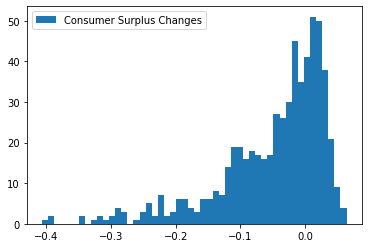

In [22]:
# pre-merger consumer surplus
cs_pre = supply_results.compute_consumer_surpluses()
cs_post = supply_results.compute_consumer_surpluses(price_postmerger)
plt.hist(cs_post - cs_pre, bins=50);
plt.legend(["Consumer Surplus Changes"]);